In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential, mixed_precision
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import os

# Enable mixed precision for T4 GPU
mixed_precision.set_global_policy('mixed_float16')

# Use local copy (faster than Drive)
!cp -r "/content/drive/MyDrive/sign_data" "/content/sign_data"
data_dir = "/content/sign_data"

# Data pipeline
img_size = (64, 64)   # smaller = faster
batch_size = 32

# Store original dataset before prefetching
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


# Optimize dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

# Base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(64,64,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(train_ds_raw.cardinality().numpy(), activation='softmax')  # auto classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train (super fast!)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,             # try 5 first
    steps_per_epoch=20,   # short training loops
    validation_steps=5
)

Found 6344 files belonging to 6 classes.
Using 5076 files for training.
Found 6344 files belonging to 6 classes.
Using 1268 files for validation.


/tmp/ipython-input-3146641025.py:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 159)            │        10,335 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,350,303 (8.97 MB)

 Trainable params: 92,319 (360.62 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 761ms/step - accuracy: 0.0367 - loss: 5.6183 - val_accuracy: 0.5063 - val_loss: 2.3846
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4081 - loss: 2.9037 - val_accuracy: 0.4938 - val_loss: 1.4548
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4332 - loss: 1.9486 - val_accuracy: 0.5250 - val_loss: 1.2053
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3866 - loss: 1.6508 - val_accuracy: 0.5250 - val_loss: 1.1517
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4569 - loss: 1.4567 - val_accuracy: 0.5688 - val_loss: 1.0332


In [6]:
# Unfreeze last few layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:  # freeze all except last 30 layers
    layer.trainable = False

# Recompile with lower LR
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train again (fine-tuning)
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,   # even 5 epochs is enough
    steps_per_epoch=20,
    validation_steps=5
)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 735ms/step - accuracy: 0.2802 - loss: 2.8223 - val_accuracy: 0.8375 - val_loss: 0.3971
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3141 - loss: 2.5096 - val_accuracy: 0.8750 - val_loss: 0.3631
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3957 - loss: 2.1723 - val_accuracy: 0.8500 - val_loss: 0.4223
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4305 - loss: 2.0068 - val_accuracy: 0.8625 - val_loss: 0.3819
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4929 - loss: 1.6885 - val_accuracy: 0.8125 - val_loss: 0.4652


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

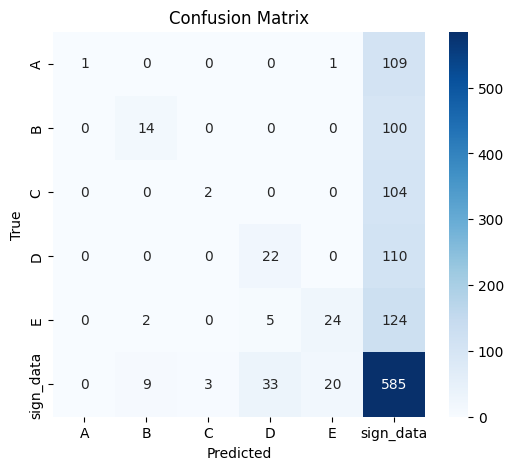

Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.01      0.02       111
           B       0.56      0.12      0.20       114
           C       0.40      0.02      0.04       106
           D       0.37      0.17      0.23       132
           E       0.53      0.15      0.24       155
   sign_data       0.52      0.90      0.66       650

    accuracy                           0.51      1268
   macro avg       0.56      0.23      0.23      1268
weighted avg       0.54      0.51      0.41      1268



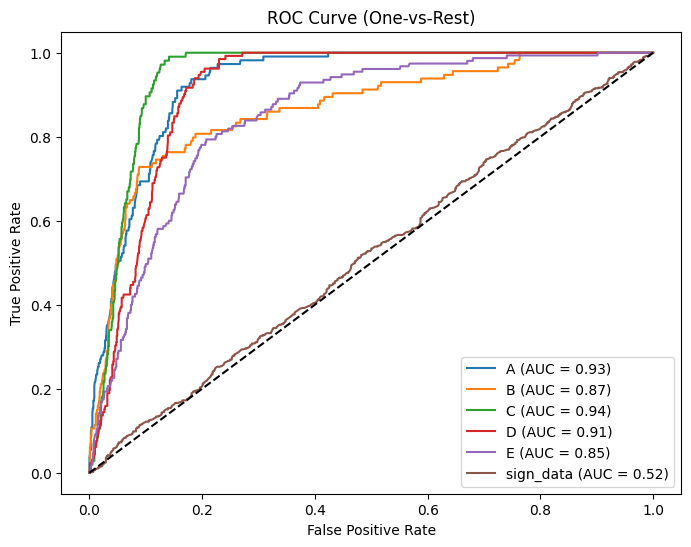

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ✅ Assume you have `model`, `val_ds`, and `class_names`

# Step 1: Get predictions
y_true = []
y_pred = []
y_pred_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_prob.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Get class names from the training dataset
class_names = train_ds_raw.class_names

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Step 4: ROC Curve (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(8,6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Sign: A


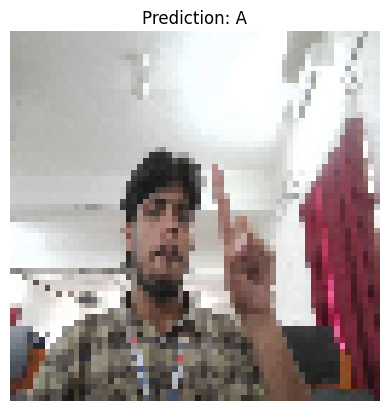

In [25]:
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Function to capture image from webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# 📷 Capture from webcam
filename = take_photo()

# Load and preprocess
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (64,64))  # same size as training
img_array = img_to_array(img_resized)/255.0
img_array = np.expand_dims(img_array, axis=0)

# Get class names from the training dataset
class_names = train_ds_raw.class_names

# 🔮 Predict
pred = model.predict(img_array)

# Find the index of 'sign_data' and remove its probability
if 'sign_data' in class_names:
    sign_data_index = class_names.index('sign_data')
    pred_without_sign_data = np.delete(pred[0], sign_data_index)
    # Get the predicted class index from the modified array
    predicted_class_index_modified = np.argmax(pred_without_sign_data)

    # Map the modified index back to the original class names (excluding sign_data)
    # Create a new list of class names without 'sign_data'
    class_names_without_sign_data = [name for name in class_names if name != 'sign_data']
    pred_class = class_names_without_sign_data[predicted_class_index_modified]
else:
    # If 'sign_data' is not in class names (shouldn't happen based on context)
    pred_class = class_names[np.argmax(pred[0])]


print("Predicted Sign:", pred_class)

# Show captured image
plt.imshow(img_resized)
plt.title(f"Prediction: {pred_class}")
plt.axis("off")
plt.show()

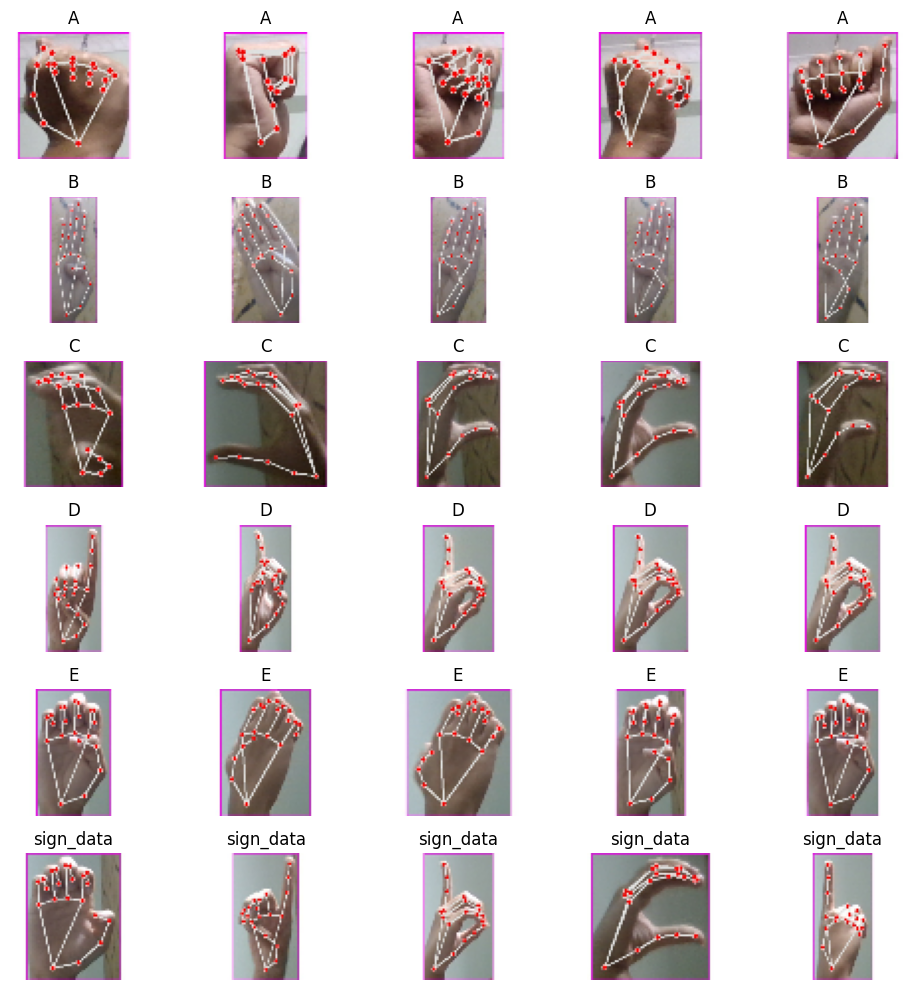

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the training dataset
class_names = train_ds_raw.class_names

# Number of images to display per class
num_images_per_class = 5

plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    # Get images and labels for the current class
    class_ds = train_ds_raw.unbatch().filter(lambda image, label: tf.argmax(tf.one_hot(label, depth=len(class_names))) == i).take(num_images_per_class)

    for j, (image, label) in enumerate(class_ds):
        ax = plt.subplot(len(class_names), num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()